##Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset , Subset
import matplotlib.pyplot as plt
import numpy as np
import os, urllib.request, zipfile

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# **1. Load dSprites Dataset**

In [4]:
class dSpritesDataset(Dataset):
    def __init__(self, path="//content/drive/MyDrive/Colab Notebooks/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"):
        data = np.load(path, allow_pickle=True, encoding="latin1")
        self.imgs = data['imgs']  # (737280, 64, 64) binary images

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = torch.tensor(self.imgs[idx], dtype=torch.float32).unsqueeze(0)
        return img, 0  # dummy label


# Create dataset
train_dataset = dSpritesDataset()

# smaller subset for faster training (first 100k samples)
small_dataset = Subset(train_dataset, range(100000))

# DataLoader
train_loader = DataLoader(small_dataset, batch_size=128, shuffle=True)


# **2. Define β-VAE**

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(64*64, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 64*64)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))
        return x_recon.view(-1, 1, 64, 64)

class BetaVAE(nn.Module):
    def __init__(self, latent_dim=10, beta=4):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.beta = beta

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# **3. Loss Function**

In [7]:
def vae_loss(x, x_recon, mu, logvar, beta=4):
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum') / x.size(0)

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    Loss = recon_loss + beta * kl_loss

    return Loss


# **4. Train the Model**

In [8]:
model = BetaVAE(latent_dim=10, beta=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_history = []

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(batch)
        loss = vae_loss(batch, x_recon, mu, logvar, beta=model.beta)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader.dataset)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

Epoch [1/5] Loss: 1.6079
Epoch [2/5] Loss: 0.9487
Epoch [3/5] Loss: 0.9040
Epoch [4/5] Loss: 0.8773
Epoch [5/5] Loss: 0.8618


# **5. Plot Training Loss Curve**

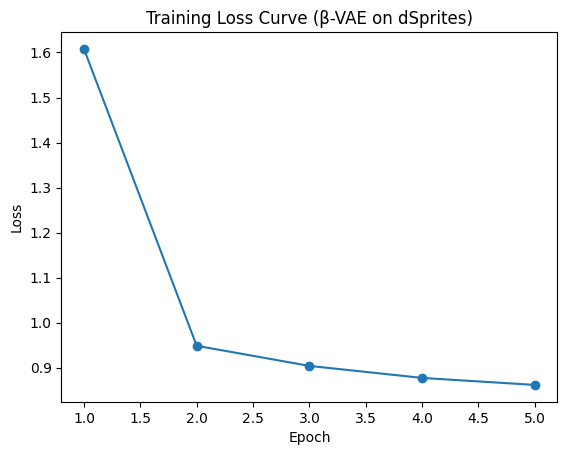

In [9]:
plt.plot(range(1, epochs+1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve (β-VAE on dSprites)")
plt.show()

# **6. Show Reconstructions**

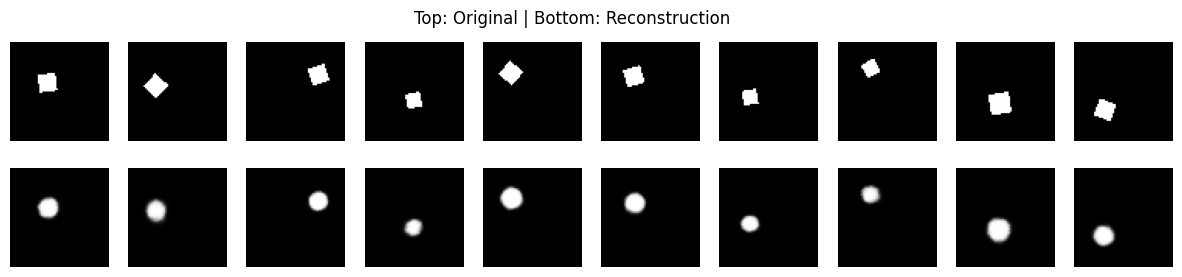

In [10]:
def show_reconstructions():
    batch, _ = next(iter(train_loader))
    batch = batch.to(device)
    with torch.no_grad():
        x_recon, _, _ = model(batch)
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0, i].imshow(batch[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(x_recon[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle("Top: Original | Bottom: Reconstruction")
    plt.show()

show_reconstructions()

# **7. Latent Traversal Grid**

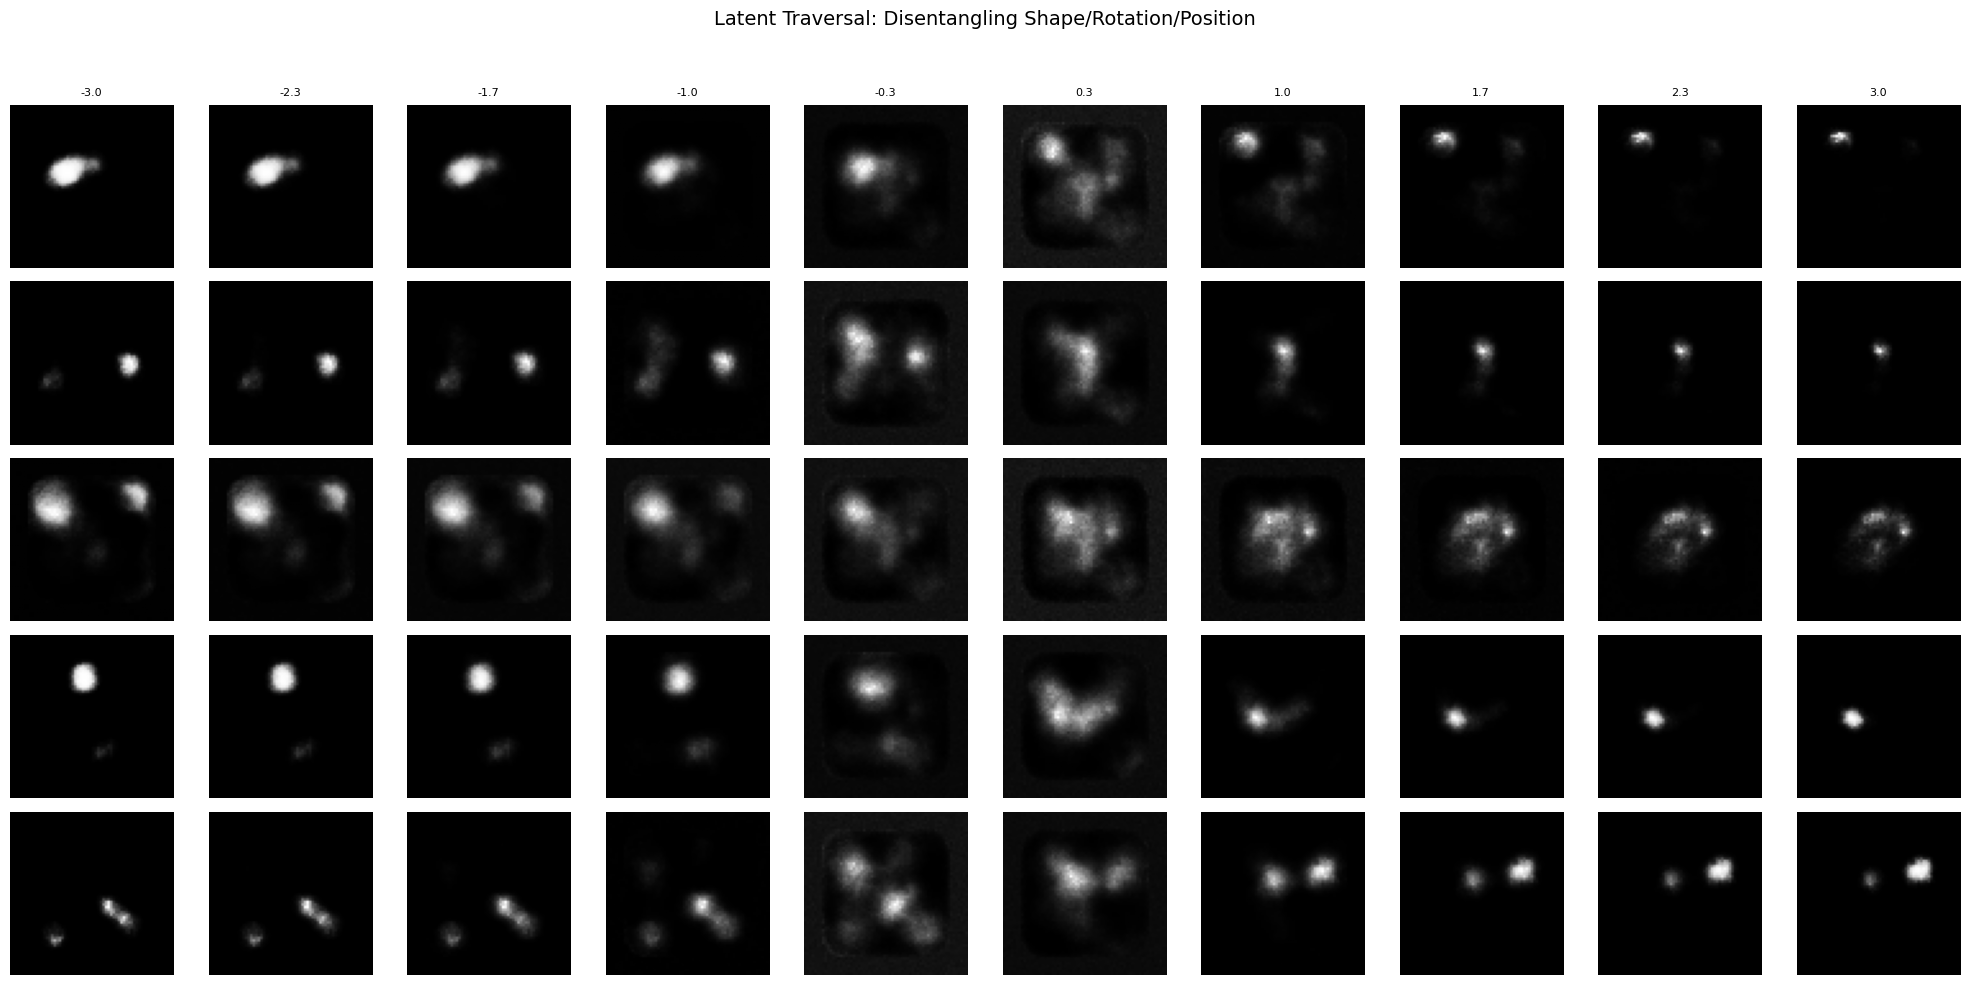

In [11]:
def latent_traversal_grid(num_dims=5, num_steps=10):
    fig, axes = plt.subplots(num_dims, num_steps, figsize=(2*num_steps, 2*num_dims))
    latent_dim = 10
    values = torch.linspace(-3, 3, num_steps)

    for d in range(num_dims):
        z = torch.zeros((num_steps, latent_dim)).to(device)
        z[:, d] = values  # vary the d-th latent dimension
        with torch.no_grad():
            samples = model.decoder(z)

        for i in range(num_steps):
            axes[d, i].imshow(samples[i].cpu().squeeze(), cmap='gray')
            axes[d, i].axis('off')
            if d == 0:
                # label top row with latent value
                axes[d, i].set_title(f"{values[i]:.1f}", fontsize=8)
        # label the row with the latent dimension
        axes[d, 0].set_ylabel(f"Dim {d}", rotation=0, labelpad=40, fontsize=10, va='center')

    plt.suptitle("Latent Traversal: Disentangling Shape/Rotation/Position", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

latent_traversal_grid()
